/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
6003/6003 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - auc: 0.6361 - loss: 0.2113 - val_auc: 0.7958 - val_loss: 0.1230
Epoch 2/100
6003/6003 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - auc: 0.7762 - loss: 0.1258 - val_auc: 0.7988 - val_loss: 0.1221
Epoch 3/100
6003/6003 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - auc: 0.7907 - loss: 0.1239 - val_auc: 0.8014 - val_loss: 0.1217
Epoch 4/100
6003/6003 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - auc: 0.7874 - loss: 0.1241 - val_auc: 0.8052 - val_loss: 0.1212
Epoch 5/100
6003/6003 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - auc: 0.7928 - loss: 0.1229 - val_auc: 0.8048 - val_loss: 0.1212
Epoch 6/100
6003/6003 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - auc: 0.7978 - loss: 0.1210 - val_auc: 0.8043 - val_loss: 0.1213
Epoch 7/100
6003/6003 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - auc: 0.8012 - loss: 0.1213 - val_auc: 0.8074 - val_loss: 0.1208
Epoch 8/100
6003/6003 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - auc: 0.8010 - loss: 0.1221 - val_auc: 0.8058 - val_loss: 0.1210
Epoch 9/100
6003/6003 ━━

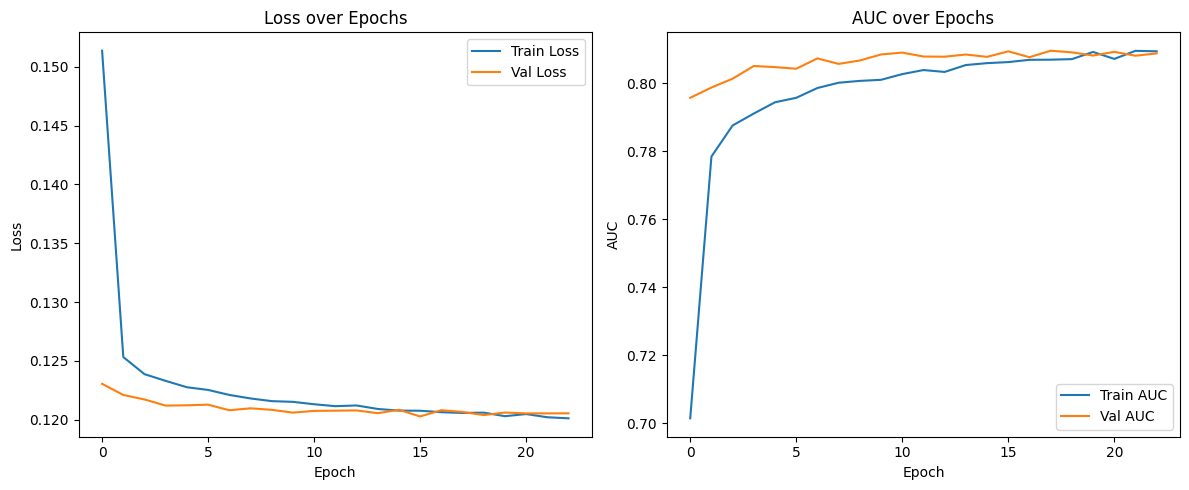

In [16]:
# === 📦 Import Modules ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, PReLU
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === Load & Clean Data ===
df = pd.read_parquet("../data/train_data.parquet")

# 處理類別欄位：Label Encoding
categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# 處理缺失值
df = df.fillna(-999)

# === Split Features & Labels ===
drop_cols = ["case_id", "date_decision", "target"]
X = df.drop(columns=drop_cols)
y = df["target"]

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Feature Scaling ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# === Build Model ===
model = Sequential([
    Dense(128, input_dim=X_train.shape[1]),
    PReLU(),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# === Compile Model ===
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name="auc")]
)

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("../output/model/nn_best_model.keras", monitor='val_auc', mode='max', save_best_only=True)

# === Train Model ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# === Plot Loss & AUC ===
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()
